# Ensemble Docking Results per protein conformation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../..')
from helper_modules.plotting_metrics import PlotMetric 
from helper_modules.run_or_load import run_or_load

## Load the available data
- This dataframe have been computed in previous notebooks.

### Protein metadata

In [2]:
DIR = '../1_Download_and_prepare_protein_ensembles'
path_to_file = f'{DIR}/TABLA_MTDATA_CDK2_402_crys_LIGS_INFO.json'
df_prot = pd.read_json(path_to_file)

#### Include pocket volume information

In [3]:
DIR = '../3_Protein_Ensembles_Analysis/'
path_to_file = f'{DIR}/POVME3_results/Pocket_alignment/res_output.txt'
# Read the pocket volume results
df_pocket = pd.read_csv(path_to_file,
                        sep = '|', 
                        skiprows=844, 
                        header=None, 
                        skipfooter=3, 
                        engine='python',
                        names=['pdb_id', 'volumen', 'surf_area'], 
                        index_col=0)

# Include it to the main dataframe
df_pocket.index = df_prot.index
df_pocket = df_prot.merge(df_pocket, 
                          how='inner', 
                          left_index=True, 
                          right_index=True)

## Compute some extra properties

- It is an *apo* or an *holo* conformation?

In [4]:
df_pocket['Apo'] = ['holo' if i > 0 else 'apo' for i in df_pocket.NumLigs] 

# How many of each are there?
print('Number of Apo and Holo conformations:')
df_pocket['Apo'].value_counts()

Number of Apo and Holo conformations:


holo    395
apo       7
Name: Apo, dtype: int64

- Is the protein bound to other proteic entities?

In [5]:
df_pocket['Single Entity'] = ['bound' if i > 1 else 'single' 
                              for i in df_pocket.Entities] 
# How many of each are there?
print('Number of `single` and `bound` crystalized conformations:')
df_pocket['Single Entity'].value_counts()

Number of `single` and `bound` crystalized conformations:


single    286
bound     116
Name: Single Entity, dtype: int64

- Be sure that entries with no cocrystalized molecules have a `0` in their `Inhib_mass` column.

In [6]:
# Fill Na values inside Inhib_mass column with 0's
df_pocket['Inhib_mass'] = pd.to_numeric(
                                df_pocket['Inhib_mass']).fillna(0)

### Loading docking results

In [7]:
prot_name = 'cdk2'
file_name = '../4_Ensemble_docking_results/' + \
            'df_DkSc_results_COCRYS_CSAR_DEKOIS_DUD.pkl'
df_dk_res = pd.read_pickle(file_name)

# Extract the features columns: Docking scores
X_dksc = df_dk_res.drop('activity', axis = 1)
X = X_dksc.values
# Extract the response variable: Activity
y = df_dk_res['activity'].values

In [8]:
# Proportion of active molecules R_2
R_a = round(y.sum() / len(y), 4)

#### Get the individual performances (single-conformation performances)
- AUC-ROC
- Normalized Enrichment Factor

In [9]:
# AUC ROC
metric_params = {'metric_name': 'roc_auc'}
roc_auc = PlotMetric(y, X_dksc,
                        decreasing=True)\
                    .format_metric_results(rounded=5, 
                                           **metric_params)


# Normalized Enrichment Factor Ra=12
metric_params = {'metric_name': 'ef', 
                 'fraction': 0.12, 
                 'method':'normalized'}
nef_012 = PlotMetric(y, X_dksc,
                        decreasing=True)\
                    .format_metric_results(rounded=5, 
                                           **metric_params)

# Merge all dataframes
df_merged = df_pocket.join([roc_auc, nef_012], how='inner')

## Format and Visualize the final dataframe

In [10]:
# Rename some columns for a better visualization
last_vars = ['Resolution', 'Inhib_mass', 'volumen', 
             'surf_area', 'Apo', 'Single Entity', 
             'ROC AUC', 'EF']
new_names = ['Resolution', 'Inhib. MW', 'Pk. Volume', 
             'Pk. SASA', 'Apo', 'Single Entity', 
             'AUC-ROC', 'NEF']
df_final = df_merged[last_vars].rename(
                columns=dict(zip(last_vars, new_names)))
df_final.columns

Index(['Resolution', 'Inhib. MW', 'Pk. Volume', 'Pk. SASA', 'Apo',
       'Single Entity', 'AUC-ROC', 'NEF'],
      dtype='object')

#### Save the final dataframe for futher analysis

In [11]:
# Save the final dataframe
@run_or_load
def save_df(filename, df):
    return df

# Save it
path_to_file = f'./TABLE_Confs_Features_and_performances_{prot_name}.pkl'
df_final = save_df(path_to_file, df_final)

File loaded: ./TABLE_Confs_Features_and_performances_cdk2.pkl


### Visualize correlations among the computed properties

In [12]:
# Define some useful functions
from scipy.stats import pearsonr, spearmanr

def calculate_pvalues(df, func = spearmanr):
    ''' A simple function to compute correlation
        p-values '''
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns = df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(func(df[r], df[c])[1], 4)
    return pvalues

def corrfunc(x, y, func = spearmanr, **kwargs):
    ''' A simple function to compute correlation
        between to given variables, and visualize it using
        a pairplot figure
    '''
    r, _ = func(x, y, **kwargs)
    ax = plt.gca()
    ax.annotate(r"$\rho$ = {:.2f}".format(r), 
                fontsize=14,
                xy=(.1, .9), 
                xycoords=ax.transAxes)
    

#### Spearman correlation

In [13]:
print('Spearman correlation:')
display(df_final.corr(method='spearman'))

print('p-values:')
display(calculate_pvalues(df_final))

Spearman correlation:


,Resolution,Inhib. MW,Pk. Volume,Pk. SASA,AUC-ROC,NEF
Resolution,1.000000,0.107123,0.456019,0.193254,0.174428,-0.027653
Inhib. MW,0.107123,1.000000,0.299617,0.121486,0.376494,0.322069
Pk. Volume,0.456019,0.299617,1.000000,0.492225,0.196941,0.047071
Pk. SASA,0.193254,0.121486,0.492225,1.000000,-0.118342,-0.207717
AUC-ROC,0.174428,0.376494,0.196941,-0.118342,1.000000,0.808929
NEF,-0.027653,0.322069,0.047071,-0.207717,0.808929,1.000000


p-values:


,Resolution,Inhib. MW,Pk. Volume,Pk. SASA,AUC-ROC,NEF
Resolution,0,0.0318,0,0.0001,0.0004,0.5804
Inhib. MW,0.0318,0,0,0.0148,0,0
Pk. Volume,0,0,0,0,0.0001,0.3465
Pk. SASA,0.0001,0.0148,0,0,0.0176,0
AUC-ROC,0.0004,0,0.0001,0.0176,0,0
NEF,0.5804,0,0.3465,0,0,0


#### Visualize the relationship using a *pairplot*

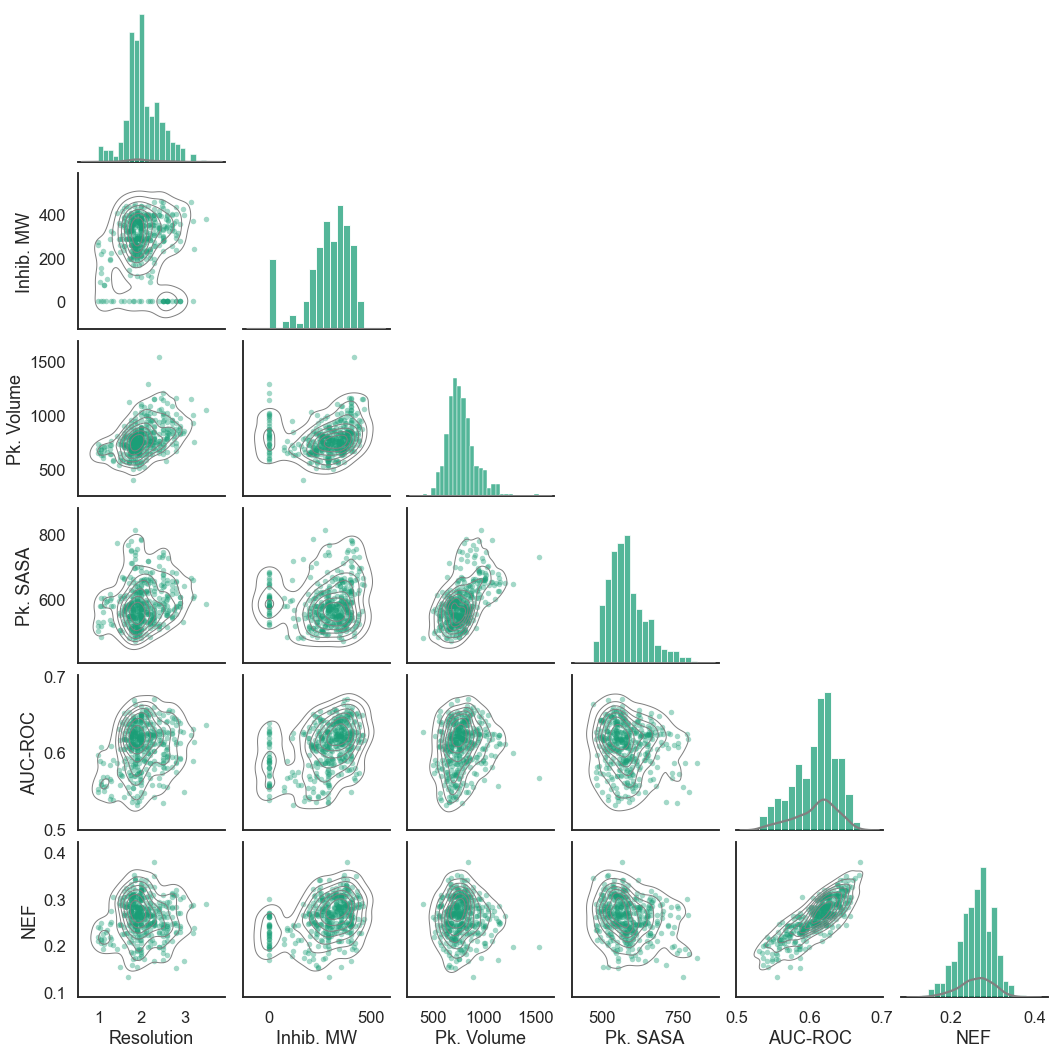

In [14]:
g = sns.pairplot(df_final, 
                 diag_kind = "hist", 
                 corner    = True,  
                 plot_kws = {'alpha': 0.4, 
                             's': 30, 
                             'edgecolor': 'k', 
                             'linewidth': 0})
g.map_lower(sns.kdeplot, levels = 8, 
            color = ".5", linewidths = 1)
g.map_diag(sns.kdeplot, color = '.5')
g.map_lower(corrfunc)
plt.show()

Finished!